In [1]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Load testing models

In [3]:
models_folder_path = pathlib.Path('../workflow/output/model')
superstructures_models_folder_path = models_folder_path / 'pv-segmentation'
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'

# Sections models
model_superstructures = torch.load(str(superstructures_models_folder_path / 'rid-mix_best.pth'), map_location=torch.device(device))

# Rooftop models
model_inria_aug_10e = torch.load(str(rooftop_models_folder_path / 'inria-aug-10e.pth'), map_location=torch.device(device))
model_inria_aug_5e = torch.load(str(rooftop_models_folder_path / 'inria-aug-5e.pth'), map_location=torch.device(device))
model_inria_raw_10e = torch.load(str(rooftop_models_folder_path / 'inria-raw-10e.pth'), map_location=torch.device(device))
model_inria_raw_5e = torch.load(str(rooftop_models_folder_path / 'inria-raw-5e.pth'), map_location=torch.device(device))

# Testing folder paths

In [4]:
rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_superstructures_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

# Metrics

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

# Helper functions

In [6]:
def test_model_superstructures(model, test_folder, num_classes, background_class, ignore_index, output=True):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]


        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

def test_model_twolook(rooftop_model,
                       sections_model,
                       test_folder,
                       num_classes,
                       background_class_1,
                       background_class_2,
                       ignore_index,
                       output=True
                      ):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        roofs = prediction.segment_img(image, rooftop_model, tile_size=512, stride=512, background_class=background_class_1)
        filtered = np.ones(image.shape).astype(np.uint8)
        idx=(roofs!=0)
        filtered[idx] = image[idx]

        pred = prediction.segment_img(filtered, sections_model, tile_size=512, stride=512, background_class=background_class_2)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')

    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

# Results

In [7]:
num_classes = 9
background_class = 0
ignore_index = -1

In [8]:
print(f'Testing model rid-mix_best...')

iou, mean_iou, elapsed_time = test_model_superstructures(model_superstructures,
                                                              rid_test_folder,
                                                              num_classes,
                                                              background_class,
                                                              ignore_index,
                                                              output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model rid-mix_best...


/tmp/ipykernel_1119234/2211447578.py:42: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.46178370764662713
IoU per class: [0.82819265 0.63668903 0.43154449 0.         0.30062006 0.48887912
 0.36404658 0.12439111 0.98169033]
Elapsed time: 434.7862045764923 seconds.


# Two-look

In [9]:
background_class_1 = 0
background_class_2 = 0

rooftop_models = [model_inria_raw_5e, model_inria_aug_5e, model_inria_raw_10e, model_inria_aug_10e]
superstructures_models = [model_superstructures]

table_ious = np.zeros((len(rooftop_models), len(superstructures_models)))

for i, rooftop_model in enumerate(rooftop_models):
    for j, superstructure_model in enumerate(superstructures_models):
        print(f'Testing two look models {i} and {j}...')
        iou, mean_iou, elapsed_time = test_model_twolook(rooftop_model,
                                                         superstructure_model,
                                                         rid_test_folder,
                                                         num_classes,
                                                         background_class_1,
                                                         background_class_2,
                                                         ignore_index,
                                                         output=False)
        table_ious[i][j] = mean_iou
        print(f'Mean IoU: {mean_iou}')
        print(f'IoU per class: {iou}')
        print(f'Elapsed time: {elapsed_time} seconds.')

Testing two look models 0 and 0...


/tmp/ipykernel_1119234/2211447578.py:114: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.2691622529975797
IoU per class: [0.66883957 0.24948781 0.26575931 0.         0.1116928  0.14902475
 0.         0.00891387 0.96874218]
Elapsed time: 884.6088759899139 seconds.
Testing two look models 1 and 0...
Mean IoU: 0.29284706557858037
IoU per class: [0.64993212 0.35869933 0.28526444 0.         0.1444512  0.21707863
 0.         0.00885401 0.97134387]
Elapsed time: 981.472959280014 seconds.
Testing two look models 2 and 0...
Mean IoU: 0.27155292135323184
IoU per class: [0.64725751 0.27370531 0.26570835 0.         0.12335337 0.15377954
 0.         0.01058808 0.96958413]
Elapsed time: 883.6091823577881 seconds.
Testing two look models 3 and 0...
Mean IoU: 0.2817700246178898
IoU per class: [0.60266127 0.34483324 0.27512576 0.         0.1430754  0.18466926
 0.00387037 0.01113222 0.97056271]
Elapsed time: 940.1987245082855 seconds.


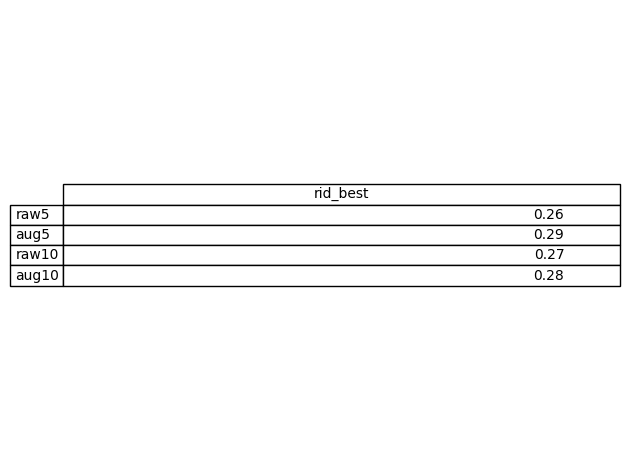

In [13]:
table_ious_rounded = (table_ious * 100).astype('int') / 100
ious_df = pd.DataFrame(data=table_ious_rounded,
             index=['raw5','aug5','raw10','aug10'],
             columns=['rid_best'])

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=ious_df.values, rowLabels=ious_df.index, colLabels=ious_df.columns, loc='center')

fig.tight_layout()

plt.show()